In [ ]:
import warnings

warnings.filterwarnings("ignore")

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy.stats import median_absolute_deviation, sigma_clip, sigma_clipped_stats
from astropy.time import Time
from fbpca import pca
from IPython.display import HTML
from matplotlib import patches
from patsy import dmatrix
from scipy.ndimage import shift
from tess_asteroids import MovingTPF, straps
from tess_asteroids.utils import animate_cube, plot_img_aperture
from tqdm import tqdm

matplotlib.rcParams["animation.embed_limit"] = 2**128

In [ ]:
# define some dates and TESS zero day
btjd0 = 2457000
mpc1st = Time("2025-05-21T22:40:14.704", format="isot", scale="utc")
discovery_date = Time("2025-07-01T05:15:11.21", format="isot", scale="utc")

In [ ]:
# we read the ephemeris file (for consistency)
# we could also query Horizon for updated ephems using `MovingTPF.from_name()`
ephem = pd.read_csv("../data/3i_s0092_1-2_ephem.csv", index_col=0)

mtpf = MovingTPF("3I/ATLAS (C/2025 N1)", ephem=ephem)
# get pixel data
mtpf.get_data(shape=(21, 21))
# creates an aperture where the target should be using TESS PRF
mtpf.create_aperture(method="prf")

Some of the requested pixels are outside of the FFI bounds (1<=row<=2078, 1<=col<=2136) and will not be returned.
Warning from TESSSpacecraft(): {message : ErfaWarning('ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"'), category : 'ErfaWarning', filename : '/Users/jimartin/miniforge3/envs/tess-asteroids/lib/python3.10/site-packages/erfa/core.py', lineno : 133, line : None}


In [ ]:
x_first = mtpf.ephemeris[np.where(mpc1st.jd > mtpf.time + btjd0)[0][-1]]

plt.figure(figsize=(9, 7))
plt.title(f"Sector {mtpf.sector} Camera {mtpf.camera} CCD {mtpf.ccd}")
plt.plot(
    mtpf.ephemeris[:, 0], mtpf.ephemeris[:, 1], c="tab:orange"
)  # interpolated JPL ephem to match FFI cadance
plt.scatter(
    mtpf.pixels[:, 0],
    mtpf.pixels[:, 1],
    c=mtpf.all_flux[1000],
    s=1,
    vmin=100,
    vmax=1000,
    marker="s",
)
plt.gca().set_aspect("equal")
# plt.gca().invert_xaxis()
plt.show()


In [6]:
# we get some variables for easy use later in background modeling
flux, flux_err = mtpf.all_flux, mtpf.all_flux_err
row, col = mtpf.pixels.T
time = mtpf.time
quality = mtpf.quality

## Remove scattered background light

In [7]:
ncomponents = 8
# We use spline as bases vectors to infill the background model where stars are.
# I set the spline with to 20 pixels
knot_width = 20
X1 = np.asarray(
    dmatrix(
        "bs(x, knots=knots, degree=3, include_intercept=False)",
        {"x": row, "knots": np.arange(row.min(), row.max(), knot_width)},
    )
)  # [:, 1:-1]
X2 = np.asarray(
    dmatrix(
        "bs(x, knots=knots, degree=3, include_intercept=False)",
        {"x": col, "knots": np.arange(col.min(), col.max(), knot_width)},
    )
)  # [:, 1:-1]
X = np.hstack([X1 * x2[:, None] for x2 in X2.T])

# we include a column-wise component to model the straps
strap_mask = (np.in1d(col, straps.Column.values + 44)).astype(float)
X = np.hstack([strap_mask[:, None], X])


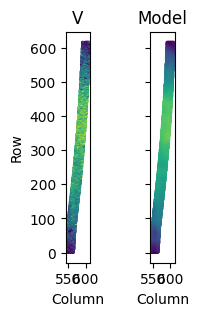

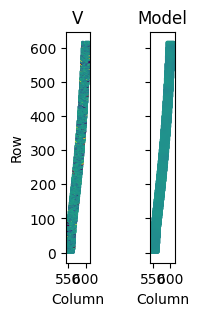

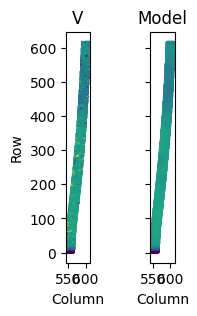

In [ ]:
# we mask out any bad frame using SPOC quality mask
time_mask = quality == 0
# we make a star mask using tess_asteroids implementation.
source_mask = mtpf._create_source_mask(include_stars=True, star_gradient_threshold=3)
# Add nan flux values to the mask (PCA cannot have nan in flux array)
source_mask |= np.isnan(mtpf.all_flux)
source_mask = source_mask.any(axis=0)

# we will model the data in chucks to account for data gaps due to data downlinks
orbit_masks = [
    np.in1d(np.arange(len(flux)), i)
    for i in np.array_split(np.arange(len(flux)), np.where(np.diff(time) > 0.1)[0] + 1)
]
# initialized the SL model
sl_model = np.zeros_like(flux)
sl_model_err = np.full(sl_model.shape, np.nan)
# we fit the model per orbit
for orbit in orbit_masks:
    time_mask = (quality == 0) & (orbit)
    # fit 8-comp PCA model to the pixel time series
    U, s, V = pca(flux[time_mask][:, ~source_mask], k=ncomponents, raw=True, n_iter=10)
    # U has the time components, and V has te spatial comp of the PCA

    # we iteratively fit a linear model to V so we can in-fill where stars are
    # we iterate to reject outlier residual
    fit_mask = np.zeros(len(row), bool)
    prior_mu = np.zeros(X.shape[1])
    prior_sigma = np.ones(X.shape[1]) * 0.5
    for sigma in [6, 5, 4]:
        # Compute best-fitting weights
        w = np.linalg.solve(
            X[~source_mask & ~fit_mask].T.dot(X[~source_mask & ~fit_mask])
            + np.diag(1 / prior_sigma**2),
            X[~source_mask & ~fit_mask].T.dot(V[:, ~fit_mask[~source_mask]].T)
            + prior_mu[:, None] / prior_sigma[:, None] ** 2,
        )
        resids = ((V.T - X.dot(w)[~source_mask]) ** 2).sum(axis=1) ** 0.5
        fit_mask[~source_mask] |= sigma_clip(resids, sigma=sigma).mask

    # some plotting of the V and V model
    fig, ax = plt.subplots(1, 2, figsize=(2, 5), sharex=True, sharey=True)
    ax[0].scatter(
        col[~source_mask], row[~source_mask], c=V[vdx], vmin=-0.02, vmax=0.02, s=1
    )
    ax[0].set(aspect="equal", xlabel="Column", ylabel="Row", title="V")
    ax[1].scatter(col, row, c=X.dot(w)[:, vdx], vmin=-0.02, vmax=0.02, s=1)
    ax[1].set(aspect="equal", xlabel="Column", title="Model")

    # now we use our linear model to interpolate V where stars are
    V_model = X.dot(w).T
    U_model = np.zeros((len(flux), ncomponents))
    U_model[time_mask] = U
    # apply the model and create the SL model with the PCA comp
    sl_model += U_model.dot(np.diag(s)).dot(V_model)

# Background Stars model

In [15]:
# we update our source mask to only include the target, as we now we want to model
# the rest, i.e. the background stars
source_mask = mtpf._create_source_mask(include_stars=False, target_threshold=0.02)
time_mask = quality == 0

In [16]:
# we make a design matrix with spline components for the time array,
# masking out bad cadences
t = time[time_mask]
X = np.asarray(
    dmatrix(
        "bs(x, knots=knots, degree=3, include_intercept=False)",
        {"x": t, "knots": np.arange(t.min(), t.max(), 0.25)},
    )
)  # [:, 1:-1]
X = np.hstack([X * orbit[time_mask, None] for orbit in orbit_masks])
# we remove small components to keep dimensionality contained
X = X[:, X.sum(axis=0) >= 1e-3]
X1 = X[:, X.sum(axis=0) >= 1e-3]
prior_mu = np.zeros(X.shape[1])
prior_sigma = np.ones(X.shape[1]) * 100000

In [17]:
# we model the background stars with a linear model
star_model = np.zeros(flux.shape)
pix_mask = np.zeros((time_mask.sum(), flux.shape[1]), bool)
# iterating over pixel, this might take some time, typically 3-5 min.
for pdx in tqdm(np.arange(0, flux.shape[1])):
    y, ye = (
        flux[:, pdx][time_mask] - sl_model[:, pdx][time_mask],
        flux_err[:, pdx][time_mask],
    )
    k = sigma_clip(np.gradient(y, t) / ye, sigma=3).mask
    k = ~np.in1d(np.arange(len(t)), np.where(k)[0][::2] + 1)
    j = ~source_mask[time_mask, pdx]
    w = np.linalg.solve(
        X[k & j].T.dot(X[k & j] / ye[k & j, None] ** 2) + np.diag(1 / prior_sigma**2),
        X[k & j].T.dot(y[k & j] / ye[k & j] ** 2) + prior_mu / prior_sigma**2,
    )
    star_model[time_mask, pdx] = X.dot(w)
    pix_mask[k, pdx] = True

100%|██████████| 13880/13880 [34:09<00:00,  6.77it/s]  


In [18]:
# we apply our SL and star model to the original data
resids = flux[time_mask] - sl_model[time_mask] - star_model[time_mask]
# for the following model fitting (positions and PSF) we will remove any 
# significant outlier pixel in time, this ensure our model are fitted with 
# uncontaminated data.
resids[~pix_mask] = np.nan
bad_pix = sigma_clip(sigma_clipped_stats(resids, axis=0)[2], sigma=3).mask
resids[:, bad_pix] = np.nan
resids[sigma_clip(resids, sigma=3).mask] = np.nan
resids[sigma_clip(resids, sigma=3).mask] = np.nan
resids_err = flux_err[time_mask]
resids_err[~np.isfinite(resids)] = np.nan

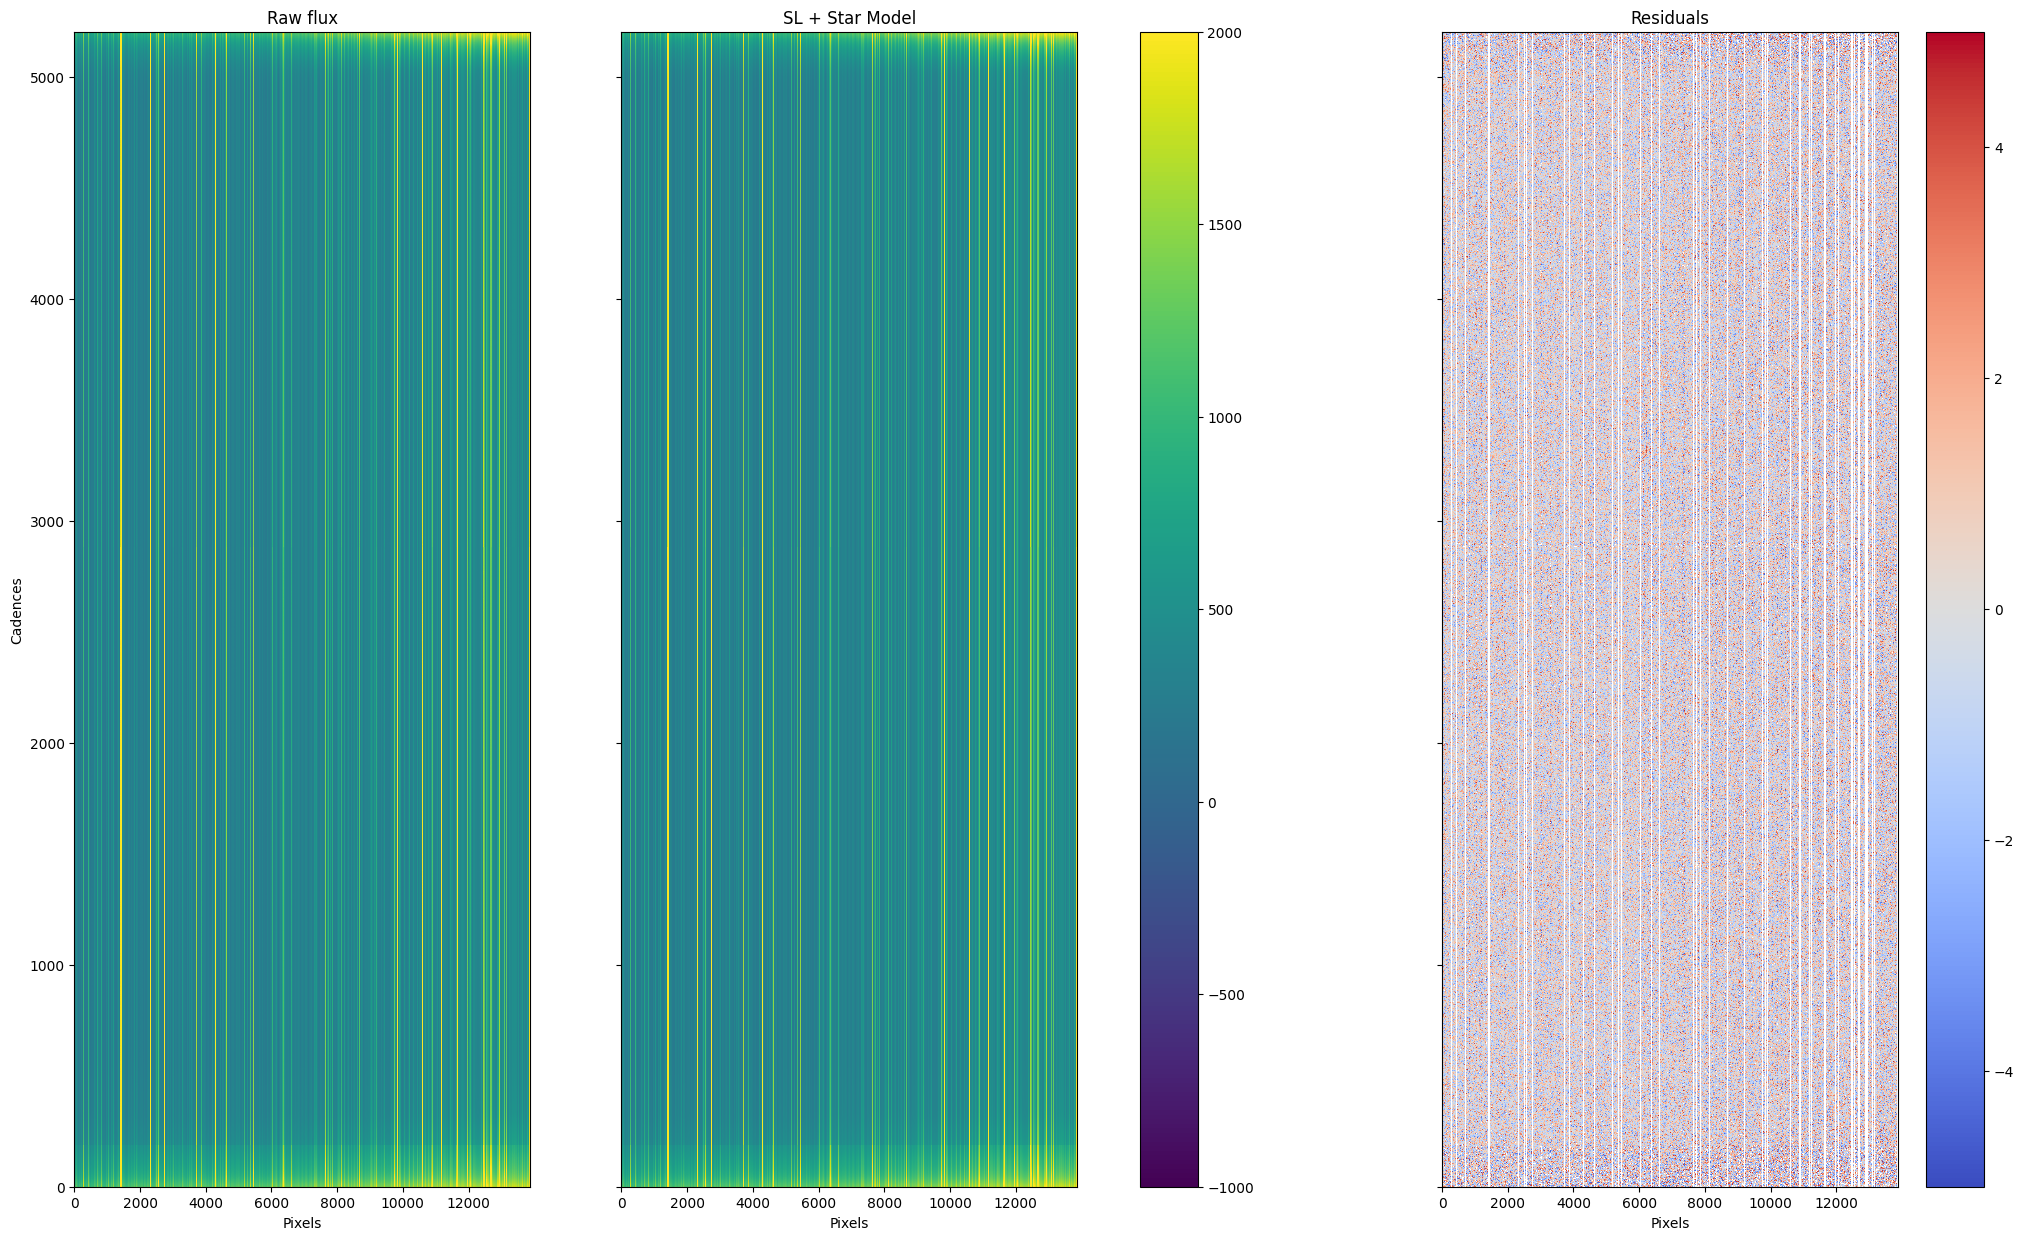

In [24]:
fig, ax = plt.subplots(1, 3, figsize=(25, 15), sharex=True, sharey=True)

bar = ax[0].imshow(
    flux[time_mask],
    origin="lower",
    aspect="auto",
    vmin=-1000,
    vmax=2000,
    interpolation="nearest",
)
bar = ax[1].imshow(
    sl_model[time_mask] + star_model[time_mask],
    origin="lower",
    aspect="auto",
    vmin=-1000,
    vmax=2000,
    interpolation="nearest",
)
plt.colorbar(bar, ax=ax[:2])
bar = ax[2].imshow(
    resids,
    origin="lower",
    aspect="auto",
    vmin=-5,
    vmax=5,
    interpolation="nearest",
    cmap="coolwarm",
)
plt.colorbar(bar, ax=ax[2])
ax[0].set_title("Raw flux")
ax[1].set_title("SL + Star Model")
ax[2].set_title("Residuals")
ax[0].set(xlabel="Pixels", ylabel="Cadences")
ax[1].set(xlabel="Pixels")
ax[2].set(xlabel="Pixels")

plt.show()

In [31]:
print("Median ", np.nanmedian(resids))
print("MAD    ", median_absolute_deviation(resids.ravel(), ignore_nan=True))
print("Mean   ", np.nanmean(resids))
print("STD    ", np.nanstd(resids))

Median  0.004243181684831399
MAD     1.0478011314158104
Mean    0.005202192253749803
STD     1.5673214406526752


## PRF Photometry

In [32]:
# we get the pixel mask that makes a target-center cutout
# of shape [nt, 21, 21]
a = mtpf.target_mask[time_mask]
resids_err = flux_err[time_mask]
# we reshape the data
resids_cube = np.asarray(
    [resids[tdx][a[tdx]].reshape(mtpf.shape) for tdx in range(time_mask.sum())]
)
resids_cube_e = np.asarray(
    [resids_err[tdx][a[tdx]].reshape(mtpf.shape) for tdx in range(time_mask.sum())]
)

In [33]:
# we get PRF models for every frame centered on the target
prf_model = mtpf._create_target_prf_model(all_flux=False)

/var/folders/9v/pf39l8vn4dv810cyn39k_xk05nh7q7/T/ipykernel_18335/1602133544.py:26: UserWarning: Adding colorbar to a different Figure <Figure size 2000x200 with 11 Axes> than <Figure size 900x300 with 1 Axes> which fig.colorbar is called on.
  plt.colorbar(bar, ax=ax, orientation="horizontal", label="Flux [e-/s]")


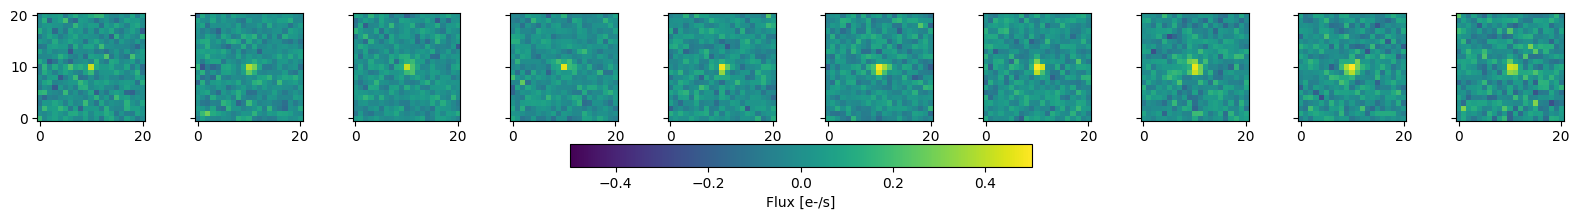

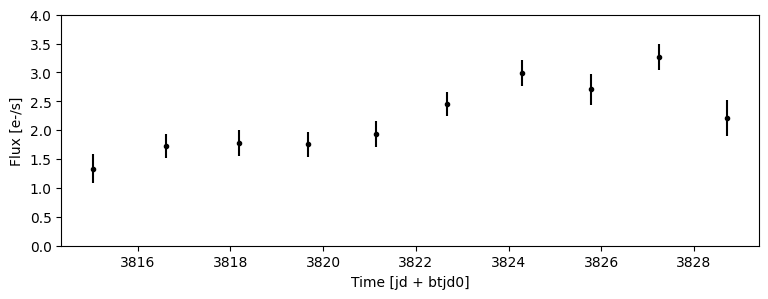

In [ ]:
# compute PRF photometry using all pixels in a time window defined by the number of
# points we want in the LC. The photometry is obtain by fitting a linear model
# with the PRF-pixel values as components
n_im = 10
prf_phot = []
fig, ax = plt.subplots(1, n_im, figsize=(20, 2), sharex=True, sharey=True)
fig2, ax2 = plt.subplots(figsize=(9,3))
for idx, t, a, ae, p in zip(
    range(n_im),
    np.array_split(time, n_im),
    np.array_split(resids_cube, n_im),
    np.array_split(resids_cube_e, n_im),
    np.array_split(prf_model[time_mask], n_im),
):
    j = np.isfinite(a.ravel()) & np.isfinite(ae.ravel())
    bar = ax[idx].imshow(sigma_clipped_stats(a, axis=0, sigma=3)[0], vmin=-0.5, vmax=0.5, origin="lower")
    X = p.ravel()[:, None]
    sigma_w_inv = X[j].T.dot(X[j] / ae.ravel()[j, None] ** 2)
    amp = np.linalg.solve(sigma_w_inv, X[j].T.dot((a.ravel()[j] / ae.ravel()[j] ** 2)))[
        0
    ]
    amp_err = np.linalg.inv(sigma_w_inv).diagonal() ** 0.5
    ax2.errorbar(t.mean(), amp, amp_err, c="k", marker=".")
    prf_phot.append([amp, amp_err[0]])
ax2.set(ylim=(0, 4), ylabel="Flux [e-/s]", xlabel="Time [jd + btjd0]")
plt.colorbar(bar, ax=ax, orientation="horizontal", label="Flux [e-/s]")
plt.show()
prf_phot = np.asarray(prf_phot)

## Fit a Model to Correct the Ephemeris

In [36]:
prf_model = mtpf._create_target_prf_model(all_flux=False)

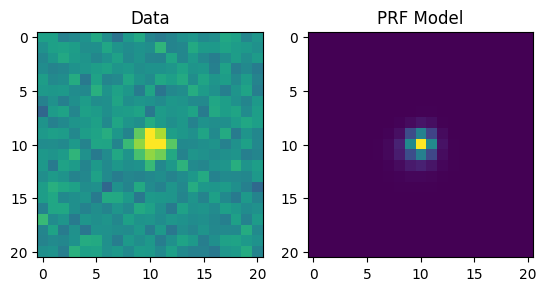

In [40]:
# first let's make sure the data is centered.
k = np.isfinite(resids_cube)

y = resids_cube.copy()
y = np.nanmean(y, axis=0)
ye = np.sqrt(np.nansum((resids_cube_e**2 * k), axis=0) / k.sum(axis=0)) / len(mtpf.time)

# this finds the best rough pixel center for the data
best_centers = np.zeros((3, 3))
for idx, shift_r in enumerate([-1, 0, 1]):
    for jdx, shift_c in enumerate([-1, 0, 1]):
        prf = prf_model[time_mask]
        prf = np.roll(np.roll(prf, shift=shift_r, axis=1), shift=shift_c, axis=2)
        dprf1, dprf2 = np.gradient(prf, axis=(1, 2))

        A = np.asarray(
            [
                prf.sum(axis=0).ravel(),
                dprf1.sum(axis=0).ravel(),
                dprf2.sum(axis=0).ravel(),
            ]
        ).T
        # y, ye = cube_flux.sum(axis=0), np.sum(cube_flux_e**2, axis=0)**0.5
        w = np.linalg.solve(
            A.T.dot(A / ye.ravel()[:, None] ** 2), A.T.dot((y / ye**2).ravel())
        )
        best_centers[idx, jdx] = np.hypot(w[1] / w[0], w[2] / w[0])

shift_r = [-1, 0, 1][np.unravel_index(np.argmin(best_centers), (3, 3))[0]]
shift_c = [-1, 0, 1][np.unravel_index(np.argmin(best_centers), (3, 3))[1]]
prf = prf_model[time_mask]
prf = np.roll(np.roll(prf, shift=shift_r, axis=1), shift=shift_c, axis=2)
dprf1, dprf2 = np.gradient(prf, axis=(1, 2))
center = mtpf.ephemeris[time_mask] - mtpf.corner[time_mask]
center[:, 0] += shift_r
center[:, 1] += shift_c

fig, ax = plt.subplots(1, 2)
ax[0].imshow(y, vmin=-0.2, vmax=0.2)
ax[0].set(title="Data")
ax[1].imshow(prf.sum(axis=0))
ax[1].set(title="PRF Model")
plt.show()


In [41]:
# now we fit a linear model for the components of the Taylor expansion that
# describe the shift in position of the target according to the data

t = (time[time_mask] - time[time_mask].mean()) / (
    time[time_mask].max() - time[time_mask].min()
)
k = np.isfinite(resids_cube).ravel()
# Initial guess of the flux model
A0 = np.asarray([(prf * (t[:, None, None] ** idx)).ravel() for idx in range(3)]).T
w = np.linalg.solve(
    A0[k].T.dot((A0 / resids_cube_e.ravel()[:, None] ** 2)[k]),
    A0[k].T.dot((resids_cube.ravel() / resids_cube_e.ravel() ** 2)[k]),
)
k &= ~sigma_clip(
    (resids_cube.ravel() - A0.dot(w)) ** 2 / resids_cube_e.ravel() ** 2, sigma=10
).mask

ast_flux = np.asarray([t**idx for idx in range(A0.shape[1])]).T.dot(w[: A0.shape[1]])


# calculate again
A0 = np.asarray(
    [
        (ast_flux[:, None, None] * prf * (t[:, None, None] ** idx)).ravel()
        for idx in range(3)
    ]
).T
A1 = np.asarray(
    [
        (ast_flux[:, None, None] * dprf1 * (t[:, None, None] ** idx)).ravel()
        for idx in range(4)
    ]
).T
A2 = np.asarray(
    [
        (ast_flux[:, None, None] * dprf2 * (t[:, None, None] ** idx)).ravel()
        for idx in range(4)
    ]
).T
A = np.hstack([A0, A1, A2])
w = np.linalg.solve(
    A[k].T.dot((A / resids_cube_e.ravel()[:, None] ** 2)[k]),
    A[k].T.dot((resids_cube.ravel() / resids_cube_e.ravel() ** 2)[k]),
)
k &= ~sigma_clip(
    (resids_cube.ravel() - A.dot(w)) ** 2 / resids_cube_e.ravel() ** 2, sigma=5
).mask
w = np.linalg.solve(
    A[k].T.dot((A / resids_cube_e.ravel()[:, None] ** 2)[k]),
    A[k].T.dot((resids_cube.ravel() / resids_cube_e.ravel() ** 2)[k]),
)
k &= ~sigma_clip(
    (resids_cube.ravel() - A.dot(w)) ** 2 / resids_cube_e.ravel() ** 2, sigma=3
).mask
w = np.linalg.solve(
    A[k].T.dot((A / resids_cube_e.ravel()[:, None] ** 2)[k]),
    A[k].T.dot((resids_cube.ravel() / resids_cube_e.ravel() ** 2)[k]),
)
sigma_w = np.linalg.inv(A[k].T.dot((A / resids_cube_e.ravel()[:, None] ** 2)[k]))

In [42]:
# now we evaluate the model and get the offsets in row and column
A0s = np.asarray([t**idx for idx in range(A0.shape[1])]).T
A1s = np.asarray([t**idx for idx in range(A1.shape[1])]).T
A2s = np.asarray([t**idx for idx in range(A2.shape[1])]).T

w_samps = np.random.multivariate_normal(w, sigma_w, size=100)
m0_samps = A0s.dot((w_samps[:, : A0.shape[1]]).T)
m1_samps = A1s.dot((w_samps[:, A0.shape[1] : A0.shape[1] + A1.shape[1]]).T)
m2_samps = A2s.dot(
    (w_samps[:, A0.shape[1] + A1.shape[1] : A0.shape[1] + A1.shape[1] + A2.shape[1]]).T
)

m1_samps /= m0_samps
m2_samps /= m0_samps

l = k.reshape(resids_cube.shape).sum(axis=(1, 2)) != 0
row_position_tweak = m1_samps.mean(axis=1), m1_samps.std(axis=1)
column_position_tweak = m2_samps.mean(axis=1), m1_samps.std(axis=1)

(-2.0, 2.0)

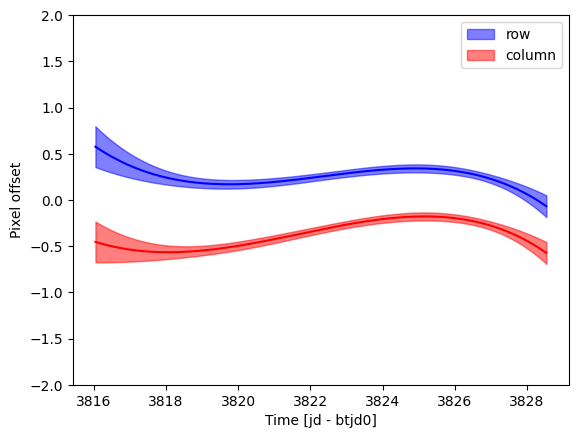

In [46]:
plt.plot(time[time_mask], row_position_tweak[0], color="b")
plt.fill_between(
    time[time_mask],
    row_position_tweak[0] - row_position_tweak[1] / 2,
    row_position_tweak[0] + row_position_tweak[1] / 2,
    alpha=0.5,
    color="b",
    label="row",
)
plt.plot(time[time_mask], column_position_tweak[0], color="r")
plt.fill_between(
    time[time_mask],
    column_position_tweak[0] - column_position_tweak[1] / 2,
    column_position_tweak[0] + column_position_tweak[1] / 2,
    alpha=0.5,
    color="r",
    label="column",
)
plt.legend()
plt.xlabel("Time [jd - btjd0]")
plt.ylabel("Pixel offset")
plt.ylim(-2, 2)

/var/folders/9v/pf39l8vn4dv810cyn39k_xk05nh7q7/T/ipykernel_18335/1312191576.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby([x_bins, y_bins])["z"].median(),
/var/folders/9v/pf39l8vn4dv810cyn39k_xk05nh7q7/T/ipykernel_18335/1312191576.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby([x_bins, y_bins])["z"].count().rename("count"),


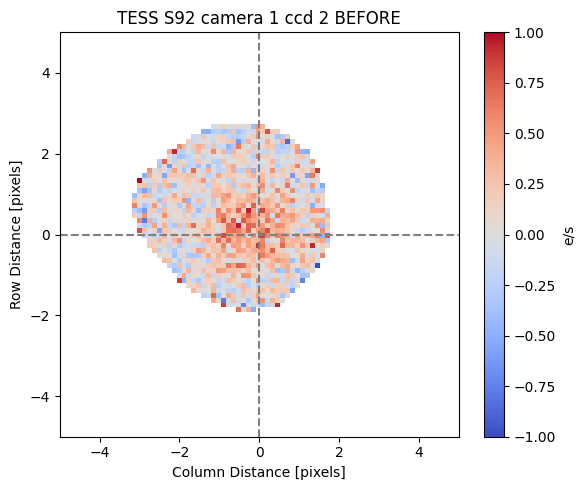

In [56]:
k = np.isfinite(resids_cube.ravel())
k &= prf.ravel() > 0.01
k &= (np.abs(resids_cube) / resids_cube_e).ravel() < 2

R, C = np.mgrid[: mtpf.shape[0], : mtpf.shape[1]]
R, C = (
    R[None, :, :] * np.ones(resids_cube.shape),
    C[None, :, :] * np.ones(resids_cube.shape),
)
R -= center[:, 0][:, None, None]
C -= center[:, 1][:, None, None]

df = pd.DataFrame(
    {
        "x": (C + column_position_tweak[0][:, None, None]).ravel()[k],
        "y": (R + row_position_tweak[0][:, None, None]).ravel()[k],
        "z": resids_cube.ravel()[k],
    }
)
# Define the bin edges for x and y
x_bins = pd.cut(df["x"], bins=40)
y_bins = pd.cut(df["y"], bins=40)

bin_means = pd.concat(
    [
        df.groupby([x_bins, y_bins])["z"].median(),
        df.groupby([x_bins, y_bins])["z"].count().rename("count"),
    ],
    axis=1,
).reset_index()

# Extract the bin centers for labeling
bin_means["x_center"] = bin_means["x"].apply(lambda x: x.mid)
bin_means["y_center"] = bin_means["y"].apply(lambda y: y.mid)


# Pivot the table for easier plotting
pivot_table_after = bin_means.pivot(index="y_center", columns="x_center", values="z")
pivot_table_w_after = bin_means.pivot(
    index="y_center", columns="x_center", values="count"
)
pivot_table_after[pivot_table_w_after < 10] = np.nan

plt.figure(figsize=(6, 5))
x_centers_after = pivot_table_after.columns
y_centers_after = pivot_table_after.index
plt.pcolormesh(
    [c for c in x_centers_after],
    [c for c in y_centers_after],
    pivot_table_after,
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
)
plt.axhline(0, ls="--", c="gray")
plt.axvline(0, ls="--", c="gray")
plt.colorbar(label="e/s")
plt.xlabel("Column Distance [pixels]")
plt.ylabel("Row Distance [pixels]")
plt.title(
    f"TESS S{mtpf.sector} camera {mtpf.camera} ccd {mtpf.ccd} BEFORE"
)
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.tight_layout()
plt.show()


/var/folders/9v/pf39l8vn4dv810cyn39k_xk05nh7q7/T/ipykernel_18335/1862269622.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby([x_bins, y_bins])["z"].median(),
/var/folders/9v/pf39l8vn4dv810cyn39k_xk05nh7q7/T/ipykernel_18335/1862269622.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby([x_bins, y_bins])["z"].count().rename("count"),


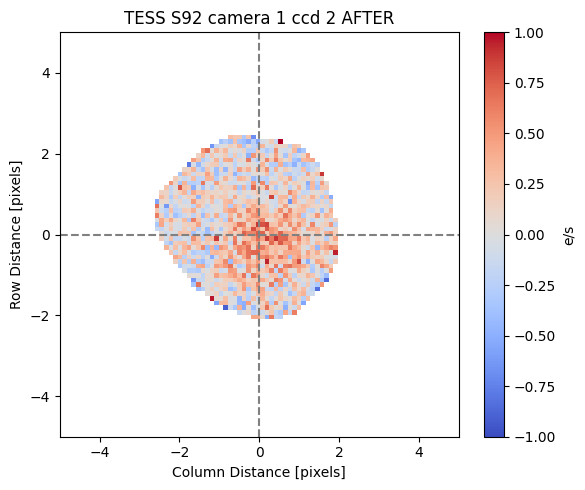

In [55]:
# let's see the aggregated data, the flux values distributed as a function of the
# target distance Before 

k = np.isfinite(resids_cube.ravel())
k &= prf.ravel() > 0.01
k &= (np.abs(resids_cube) / resids_cube_e).ravel() < 2

R, C = np.mgrid[: mtpf.shape[0], : mtpf.shape[1]]
R, C = (
    R[None, :, :] * np.ones(resids_cube.shape),
    C[None, :, :] * np.ones(resids_cube.shape),
)
R -= center[:, 0][:, None, None]
C -= center[:, 1][:, None, None]

df = pd.DataFrame({"x": C.ravel()[k], "y": R.ravel()[k], "z": resids_cube.ravel()[k]})
# Define the bin edges for x and y
x_bins = pd.cut(df["x"], bins=40)
y_bins = pd.cut(df["y"], bins=40)

bin_means = pd.concat(
    [
        df.groupby([x_bins, y_bins])["z"].median(),
        df.groupby([x_bins, y_bins])["z"].count().rename("count"),
    ],
    axis=1,
).reset_index()

# Extract the bin centers for labeling
bin_means["x_center"] = bin_means["x"].apply(lambda x: x.mid)
bin_means["y_center"] = bin_means["y"].apply(lambda y: y.mid)


# Pivot the table for easier plotting
pivot_table_before = bin_means.pivot(index="y_center", columns="x_center", values="z")
pivot_table_w_before = bin_means.pivot(
    index="y_center", columns="x_center", values="count"
)
pivot_table_before[pivot_table_w_before < 10] = np.nan

plt.figure(figsize=(6, 5))
x_centers_before = pivot_table_before.columns
y_centers_before = pivot_table_before.index
plt.pcolormesh([c for c in x_centers_before], [c for c in y_centers_before], pivot_table_before, cmap='coolwarm', vmin=-1, vmax=1)
plt.axhline(0, ls='--', c='gray')
plt.axvline(0, ls='--', c='gray')
plt.colorbar(label='e/s')
plt.xlabel('Column Distance [pixels]')
plt.ylabel('Row Distance [pixels]')
plt.title(f'TESS S{mtpf.sector} camera {mtpf.camera} ccd {mtpf.ccd} AFTER')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.tight_layout()
plt.show()

# Image Stacking

In [57]:
import lkprf
from tqdm import tqdm

In [58]:
# we get the corrected flux data again
# but we do not remove outlier pixels this time, as we need the full image 
# to do proper image registration and stacking
resids = flux[time_mask] - sl_model[time_mask] - star_model[time_mask]
resids_err = flux_err[time_mask]
resids_err[~np.isfinite(resids)] = np.nan

a = mtpf.target_mask[time_mask]
# we reshape the data
cube_flux = np.asarray(
    [resids[tdx][a[tdx]].reshape(mtpf.shape) for tdx in range(time_mask.sum())]
)
cube_flux_err = np.asarray(
    [resids_err[tdx][a[tdx]].reshape(mtpf.shape) for tdx in range(time_mask.sum())]
)

Yc, Xc = mtpf.corner[time_mask].T
times = mtpf.time[time_mask]
cadences = mtpf.cadence_number[time_mask]
cadindx = np.arange(len(times))

# we correct the target position with the model computed above
Y = mtpf.ephemeris[time_mask, 0] - row_position_tweak[0]
X = mtpf.ephemeris[time_mask, 1] - column_position_tweak[0]

In [ ]:
# this is an animation of the data, high residuals near bright stars is common due to 
# the complexity of modeling the data. But does not affect much the image stacking
# when using median statistics
ani = animate_cube(
    cube_flux,
    step=40,
    corner=mtpf.corner[time_mask],
    ephemeris=np.array([Y, X]).T,
    cadenceno=mtpf.cadence_number[time_mask],
    time=mtpf.time[time_mask],
    suptitle=f"TESS Sector {mtpf.sector} Camera {mtpf.camera} CCD {mtpf.ccd}",
    vmin=-15,
    vmax=15,
)
HTML(ani.to_jshtml())

100%|██████████| 5206/5206 [00:03<00:00, 1304.31it/s]


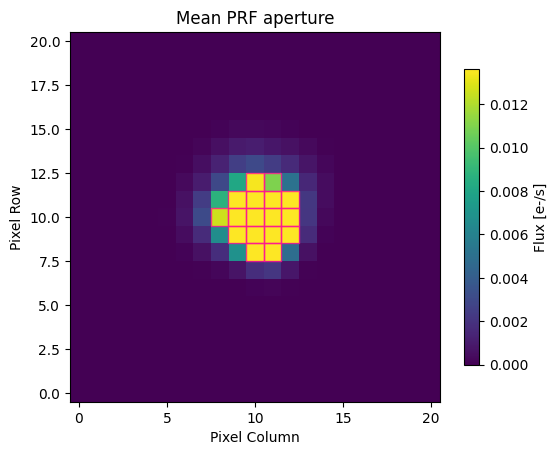

In [61]:
# we evaluate the PRF again using the corrected positions
prf = lkprf.TESSPRF(camera=mtpf.camera, ccd=mtpf.ccd)
prf_models = []

for k in tqdm(range(len(times)), total=len(times)):
    model = prf.evaluate(
        targets=(Y[k], X[k]),
        origin=(Yc[k], Xc[k]),
        shape=mtpf.shape,
    )
    prf_models.append(model[0])
prf_models = np.array(prf_models)

prf_aperture = np.nanmean(prf_models, axis=0) > 0.01
plot_img_aperture(np.nanmean(prf_models, axis=0), aperture_mask=prf_aperture)
plt.title("Mean PRF aperture")
plt.show()

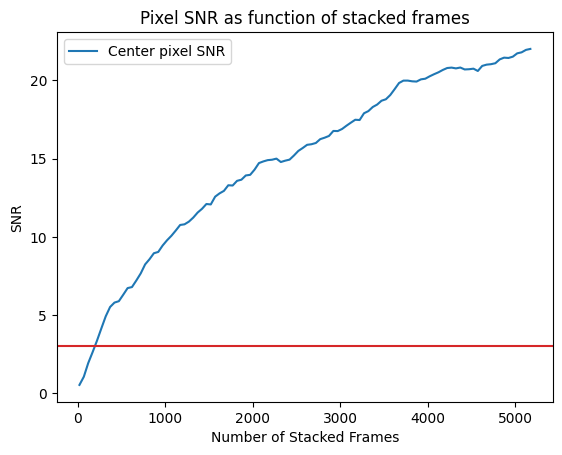

In [66]:
# we evaluate how many frames we need to stack to get SNR > 3 in the target
snrs = []
frames = np.arange(20, len(cube_flux) + 1, 50)
for nt in frames:
    # center coordinates and compute shift from center
    X_ = X - Xc
    Y_ = Y - Yc
    X_ -= X_[0]
    Y_ -= Y_[0]
    stack = []
    # do shift stack with asteroid ephems
    for k in range(len(cube_flux[:nt])):
        shift_vector = (-Y_[k], -X_[k])
        shifted_img = shift(
            cube_flux[k], shift_vector, order=3, mode="constant", cval=np.nan
        )
        stack.append(shifted_img)
    stack = np.array(stack)

    # median stack, direct_ is no shift, and track_ is with ephem shift
    track_stack = np.median(stack, axis=0)

    # compute bkg noise
    bkg_noise = np.nanstd(track_stack[~prf_aperture])

    # get center pixel SNR
    snrs.append(np.nanmax(direct_stack[prf_aperture] / bkg_noise))
snrs = np.array(snrs)

plt.plot(frames, snrs, label="Center pixel SNR")
plt.title("Pixel SNR as function of stacked frames")
plt.axhline(3, c="tab:red")
plt.legend()
plt.xlabel("Number of Stacked Frames")
plt.ylabel("SNR")
# plt.ylim(0, 30)
plt.show()

In [69]:
median = np.nanmedian(track_stack)
# SNR aperture
mad = median_absolute_deviation(track_stack.ravel(), ignore_nan=True)
snr_aperture = track_stack >= (1.4826 * mad * 3) + median
# ensure SNR mask only includes central pixels
row_s, col_s = np.mgrid[0 : track_stack.shape[0], 0 : track_stack.shape[1]]
snr_aperture &= np.hypot(row_s - row_s.mean(), col_s - col_s.mean()) <= 3

# PRF aperture
prf_aperture = np.nanmean(prf_models, axis=0) > 0.01

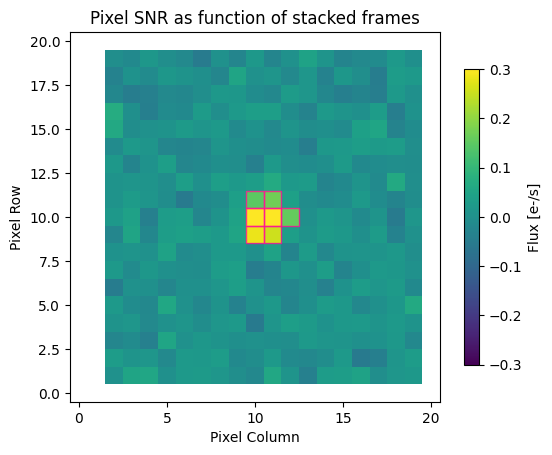

In [ ]:
ax = plot_img_aperture(
    track_stack,
    aperture_mask=snr_aperture,
    vmin=-0.3,
    vmax=0.3,
    title="Pixel SNR as function of stacked frames",
)


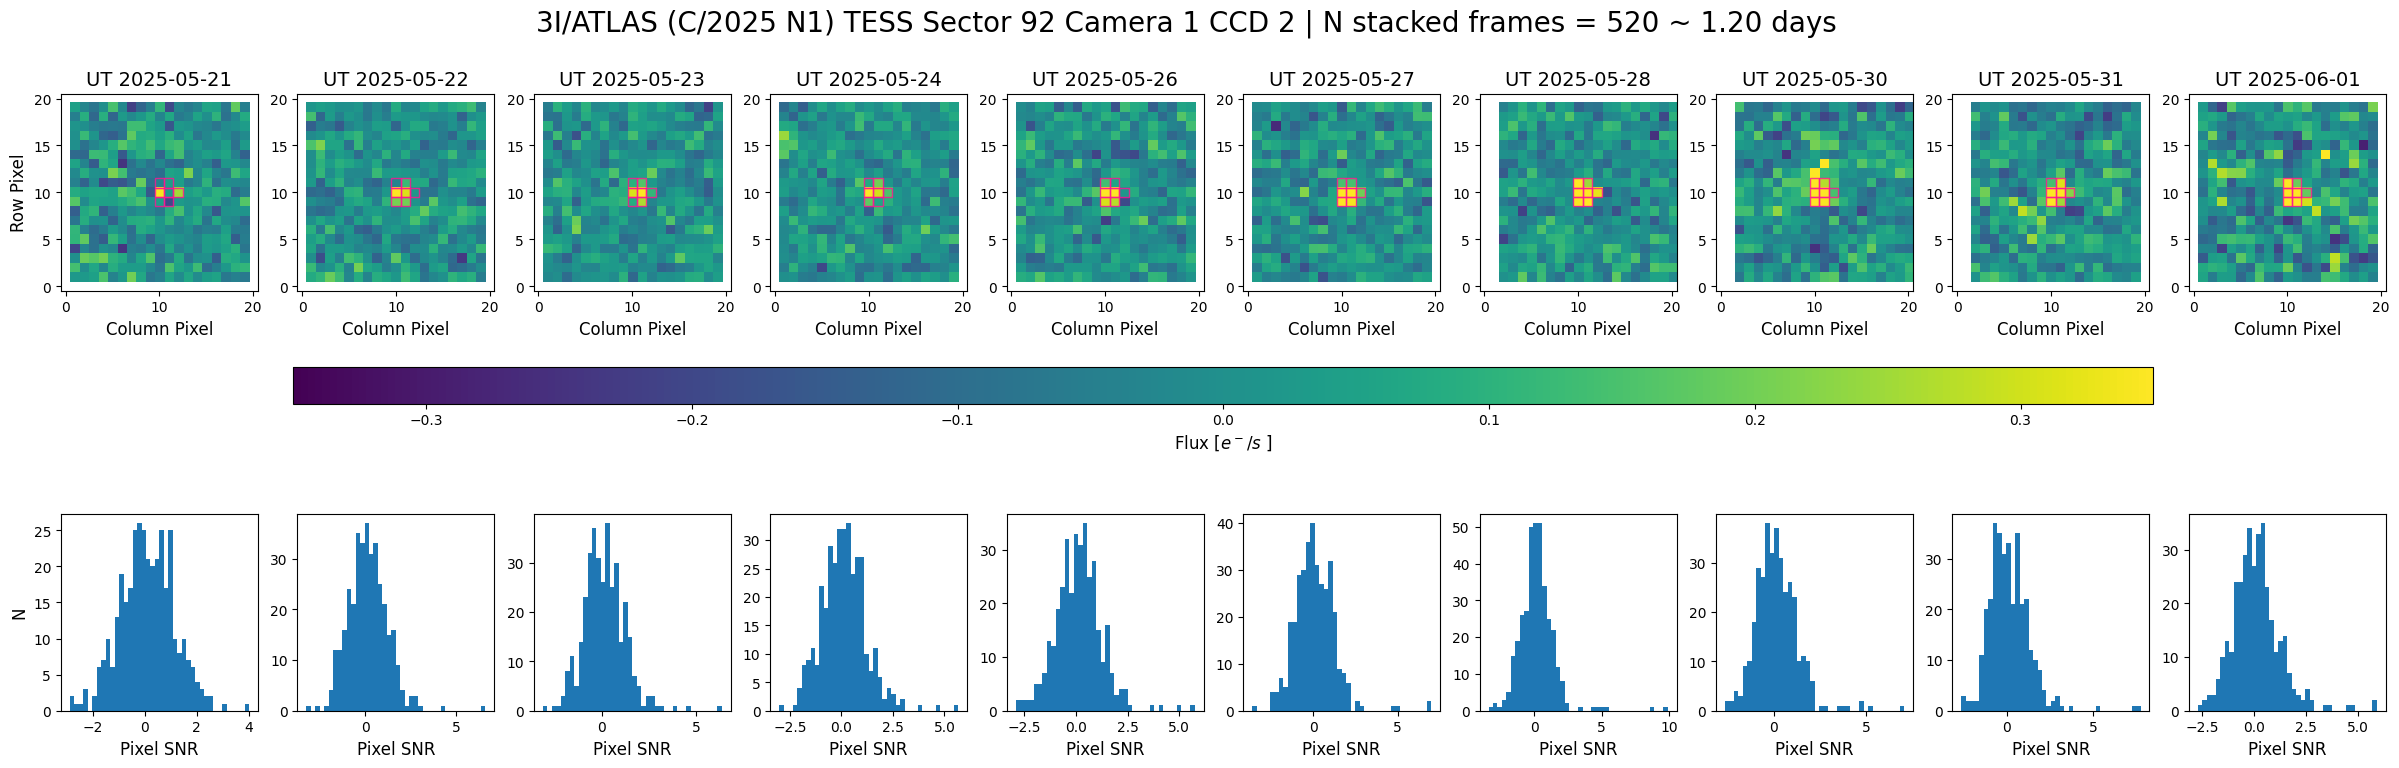

In [92]:
# now we use 500 (Camera 1 CCD 2) frames to get the stacked images
# for camera 2 CCD 3 we use 900 frames

stacked_flux = []
stacked_err = []
mid_time = []
phot = []
detect = []
# center coordinates and compute shift from center
X_ = X - Xc
Y_ = Y - Yc
X_ -= X_[0]
Y_ -= Y_[0]

# compute index array with 500 frames each
frame_idx_stack = np.array_split(cadindx, (len(cube_flux) // 500))

# dt per frame
dt = np.median(np.diff(times))

# plot stuff
fig, ax = plt.subplots(
    2,
    len(frame_idx_stack),
    figsize=(3 * len(frame_idx_stack), 9),
    sharex=False,
    sharey=False,
    height_ratios=[1.5, 1],
)
fig.suptitle(
    f"{mtpf.target} TESS Sector {mtpf.sector} Camera {mtpf.camera} CCD {mtpf.ccd} | "
    f"N stacked frames = {len(frame_idx_stack[-1])} ~ {dt * len(frame_idx_stack[-1]):.2f} days",
    y=0.92,
    fontsize=20,
)
vmin, vmax = -1, 5

for fno, frames_in in enumerate(frame_idx_stack):
    # get frames to stack in the step
    flux_aux = cube_flux[frames_in]
    flux_e_aux = cube_flux_err[frames_in]
    XX = X_[frames_in]
    YY = Y_[frames_in]
    tt = times[frames_in]

    stack_flx = []
    stack_flxe = []
    # do frame shift
    for k in range(len(flux_aux)):
        shift_vector = (-YY[k], -XX[k])
        # print(shift_vector)
        shifted_flx = shift(
            flux_aux[k], shift_vector, order=3, mode="constant", cval=np.nan
        )
        shifted_flxe = shift(
            flux_e_aux[k], shift_vector, order=3, mode="constant", cval=np.nan
        )
        stack_flx.append(shifted_flx)
        stack_flxe.append(shifted_flxe)
    stack_flx = np.array(stack_flx)
    stack_flxe = np.array(stack_flxe)

    # median stack
    stack_flx = np.median(stack_flx, axis=0)
    stack_flxe = np.median(stack_flxe, axis=0)

    # append image stack
    stacked_flux.append(stack_flx)
    stacked_err.append(stack_flxe)
    # get median time and time window
    mid_time.append([np.median(tt), median_absolute_deviation(tt), tt[-1] - tt[0]])
    # compute phot
    phot.append(
        [
            np.nansum(stack_flx[snr_aperture]),
            np.sqrt(np.nansum(stack_flxe[snr_aperture] ** 2))
            / np.sqrt(len(frames_in))
            * 2,
        ]
    )

    # compute bkg noise
    bkg_noise = np.nanstd(stack_flx[~snr_aperture])
    # number of pixels SNR>3
    detect.append(((stack_flx[snr_aperture] / bkg_noise) > 3).sum())

    # plotting stuff
    ax[0, fno].set_title(
        f'UT {Time(mid_time[-1][0] + btjd0, format="jd", scale="tdb").utc.iso[:10]}',
        fontsize=14,
    )
    # plot image
    bar = ax[0, fno].imshow(stack_flx, origin="lower", vmin=-0.35, vmax=0.35)
    ax[0, fno].set_xlabel("Column Pixel", fontsize=12)
    # add mask
    row, col = np.mgrid[0 : stack_flx.shape[0], 0 : stack_flx.shape[1]]
    for i, pi in enumerate(row[:, 0]):
        for j, pj in enumerate(col[0, :]):
            if snr_aperture[i, j]:
                # print("here")
                rect = patches.Rectangle(
                    xy=(pj - 0.5, pi - 0.5),
                    width=1,
                    height=1,
                    color="deeppink",
                    fill=False,
                    # hatch="//",
                    alpha=0.8,
                )
                ax[0, fno].add_patch(rect)

    # plot SNR hist
    ax[1, fno].hist(stack_flx.ravel() / bkg_noise, bins=40)
    ax[1, fno].set_xlabel("Pixel SNR", fontsize=12)
    ax[1, fno].set_box_aspect(1)

# add uniform colorbar
cbar = plt.colorbar(
    bar,
    ax=ax[0],
    orientation="horizontal",
    shrink=0.8,
    aspect=50,
    pad=0.2,
).set_label(label="Flux [$e^-/s$ ]", size=12)
ax[0, 0].set_ylabel("Row Pixel", fontsize=12)
ax[1, 0].set_ylabel("N", fontsize=12)

plt.show()

stacked_flux = np.array(stacked_flux)
stacked_err = np.array(stacked_err)
mid_time = np.array(mid_time)
phot = np.array(phot)
detect = np.array(detect)

In [ ]:
# np.savez(
#     f"../data/3i_s{mtpf.sector:04}_{mtpf.camera}-{mtpf.ccd}_images.npz",
#     stacked_flux=stacked_flux,
#     prf_aperture=snr_aperture,
# )

In [101]:
# compute the aperture photometry on empty background apertures to estimate
# the detection limit
empty_ap_flux = []
for k in range(len(stacked_flux)):
    aux_empty = []
    for it in range(10):
        dx = np.random.uniform(2, 9)
        dy = np.random.uniform(2, 9)
        shift_vector = (dx, dy)
        shifted_ap = shift(
            prf_aperture.astype(int), shift_vector, order=0, mode="constant", cval=0
        ).astype(bool)
        aux_empty.append(
            [
                np.nansum(stacked_flux[k][shifted_ap]),
                np.sqrt(np.nansum(stacked_err[k][shifted_ap] ** 2))
                / np.sqrt(len(frame_idx_stack[k])),
            ]
        )
    empty_ap_flux.append(np.array(aux_empty).mean(axis=0))
empty_ap_flux = np.array(empty_ap_flux)

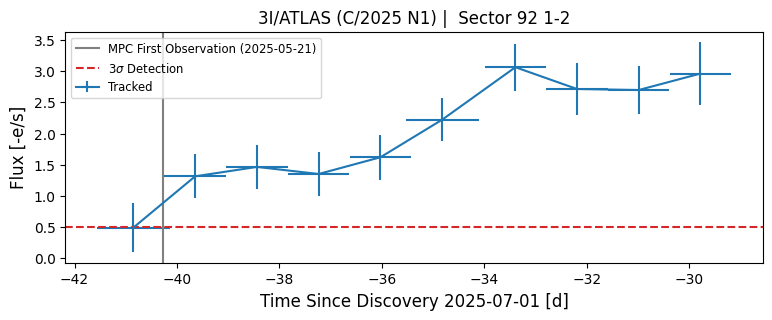

In [100]:
plt.figure(figsize=(9, 3))
plt.title(
    f"{mtpf.target} |  Sector {mtpf.sector} {mtpf.camera}-{mtpf.ccd}"
)
plt.errorbar(
    mid_time[:, 0] + btjd0 - discovery_date.jd,
    phot[:, 0],
    xerr=mid_time[:, 2] / 2,
    yerr=phot[:, 1],
    label="Tracked",
)
plt.axvline(
    (mpc1st - discovery_date).jd,
    c="gray",
    label=f"MPC First Observation ({mpc1st.iso[:10]})",
)
plt.axhline(
    np.abs(empty_ap_flux[:, 0]).mean() * 3,
    c="tab:red",
    ls="--",
    label="$3\sigma$ Detection",
)
plt.legend(loc="upper left", fontsize="small")
plt.ylabel(f"Flux [-e/s]", fontsize=12)
plt.xlabel(f"Time Since Discovery {discovery_date.iso[:10]} [d]", fontsize=12)

plt.show()

# Save Time Series data

In [90]:
# we need lkspacecraft to compute time corrections
from lkspacecraft import TESSSpacecraft

tsc = TESSSpacecraft()

/Users/jimartin/miniforge3/envs/tess-asteroids/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


In [103]:
df = pd.DataFrame(
    np.concatenate(
        [mid_time, phot, detect[:, None], empty_ap_flux], axis=1
    ),
    columns=[
        "time_tdb",
        "time_e",
        "t_win",
        "ap_flux",
        "ap_flux_err",
        "npix_detect",
        "empty_flux",
        "empty_flux_e",
    ],
)
df.time_tdb += btjd0
df["nframes"] = np.array([len(x) for x in frame_idx_stack])
df["sector"] = mtpf.sector
df["camera"] = mtpf.camera
df["ccd"] = mtpf.ccd
df["empty_flux3"] = 3 * df.empty_flux

TESSmag_zero_point = 20.44
TESSmag_zero_point_err = 0.05

df["ap_mag"] = -2.5 * np.log10(df.ap_flux) + TESSmag_zero_point
df["ap_mag_err"] = np.sqrt(
    (TESSmag_zero_point_err) ** 2
    + ((2.5 / np.log(10)) * (df.ap_flux_err / df.ap_flux)) ** 2
)

df["empty_mag"] = -2.5 * np.log10(np.abs(df.empty_flux)) + TESSmag_zero_point
df["empty_mag3"] = -2.5 * np.log10(np.abs(df.empty_flux3)) + TESSmag_zero_point

# utc at TESS
df["time_utc_sc"] = Time(df.time_tdb, scale="tdb", format="jd").utc.value

travel_time = tsc.get_spacecraft_light_travel_time(
    Time(df.time_tdb, scale="tdb", format="jd"), observer="earth"
)
# utc on Earth
df["time_utc_geo"] = df.time_utc_sc + travel_time / 3600.0 / 24.0

df["psf_flux"] = prf_phot[:, 0]
df["psf_flux_err"] = prf_phot[:, 1]

df["psf_mag"] = -2.5 * np.log10(df.psf_flux) + TESSmag_zero_point
df["psf_mag_err"] = np.sqrt(
    (TESSmag_zero_point_err) ** 2
    + ((2.5 / np.log(10)) * (df.psf_flux_err / df.psf_flux)) ** 2
)
df["v_mag"] = np.interp(
    df.time_tdb.values, mtpf.ephem.time.values + btjd0, mtpf.ephem.vmag.values
)
df["ra_ephem"] = np.interp(
    df.time_tdb.values, mtpf.ephem.time.values + btjd0, mtpf.ephem.ra.values
)
df["dec_ephem"] = np.interp(
    df.time_tdb.values, mtpf.ephem.time.values + btjd0, mtpf.ephem.dec.values
)

row_interp_corr = np.interp(df.time_tdb.values, times + btjd0, Y)
col_interp_corr = np.interp(df.time_tdb.values, times + btjd0, X)
ra_corr, dec_corr = mtpf.wcs.all_pix2world(col_interp_corr, row_interp_corr, 1)
df["ra_model"] = ra_corr
df["dec_model"] = dec_corr

df

time_tdb    time_e     t_win   ap_flux  ap_flux_err  npix_detect  \
0  2.460817e+06  0.409758  1.421420  0.490143     0.395303          1.0   
1  2.460818e+06  0.300952  1.203807  1.312930     0.355495          2.0   
2  2.460819e+06  0.300951  1.203803  1.463907     0.353419          3.0   
3  2.460820e+06  0.300950  1.203799  1.350529     0.354754          3.0   
4  2.460822e+06  0.300949  1.203795  1.618928     0.363172          4.0   
5  2.460823e+06  0.414382  1.428345  2.222280     0.347863          4.0   
6  2.460824e+06  0.300947  1.201473  3.064103     0.376945          7.0   
7  2.460826e+06  0.300946  1.201470  2.714354     0.417827          5.0   
8  2.460827e+06  0.300945  1.201467  2.698057     0.389778          4.0   
9  2.460828e+06  0.300945  1.201465  2.961463     0.503908          5.0   

   empty_flux  empty_flux_e  nframes  sector  ...  time_utc_geo  psf_flux  \
0    0.053675      0.294455      521      92  ...  2.460817e+06  1.337062   
1   -0.148969      0.259410      521      92  ...  2.460818e+06  1.724529   
2   -0.022275      0.259947      521      92  ...  2.460819e+06  1.773226   
3    0.060595      0.264448      521      92  ...  2.460820e+06  1.754678   
4    0.024868      0.272714      521      92  ...  2.460822e+06  1.939173   
5    0.159248      0.272889      521      92  ...  2.460823e+06  2.456030   
6    0.119223      0.274587      520      92  ...  2.460824e+06  2.984344   
7    0.765275      0.294302      520      92  ...  2.460826e+06  2.707853   
8   -0.475684      0.303030      520      92  ...  2.460827e+06  3.268140   
9    0.155209      0.335499      520      92  ...  2.460828e+06  2.215649   

   psf_flux_err    psf_mag  psf_mag_err      v_mag    ra_ephem  dec_ephem  \
0      0.253697  20.124621     0.211991  19.209173  286.044842 -18.704882   
1      0.213361  19.848324     0.143333  19.171682  285.803729 -18.701706   
2      0.224193  19.818090     0.146095  19.133663  285.546765 -18.697126   
3      0.217324  19.829506     0.143467  19.095503  285.277882 -18.693694   
4      0.228458  19.720958     0.137338  19.058012  284.998927 -18.692039   
5      0.210637  19.464416     0.105691  19.019312  284.710783 -18.692365   
6      0.222976  19.252878     0.095292  18.973593  284.358185 -18.695493   
7      0.264775  19.358437     0.117349  18.936076  284.052626 -18.700638   
8      0.227013  19.154248     0.090487  18.897626  283.740074 -18.708340   
9      0.308839  19.576248     0.159386  18.857976  283.422027 -18.718823   

     ra_model  dec_model  
0  286.046647 -18.701690  
1  285.804609 -18.698389  
2  285.547320 -18.694005  
3  285.278526 -18.690978  
4  284.999910 -18.689833  
5  284.712187 -18.690665  
6  284.359968 -18.694223  
7  284.054418 -18.699439  
8  283.741391 -18.706792  
9  283.422165 -18.716338  

[10 rows x 28 columns]

In [ ]:
# df.to_csv(
#     f"3i_s{mtpf.sector:04}_{mtpf.camera}-{mtpf.ccd}_lc.csv"
# )